#### Технологии обраотки больших данных для обработки терминологической информации из научно-технических текстов

### Необходимые библиотеки

In [ ]:
!pip install pymorphy2

In [ ]:
!pip install gensim

In [ ]:
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

from gensim import corpora
from gensim.corpora import Dictionary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Подключение к диску

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


### Получение данных, заранее собранных и сохраненных на диске

In [ ]:
with open(r'/content/drive/MyDrive/контент по финашке/7ой семестр/курсовая/dataset.json', 'r') as read_file:
    data = json.load(read_file)
print(data)

[{'Психическое состояние': 'Психи́ческое состоя́ние\xa0— один из возможных режимов жизнедеятельности человека, на физиологическом уровне отличающийся определёнными энергетическими характеристиками, а на психологическом уровне — системой психологических фильтров, обеспечивающих специфическое восприятие окружающего мира[источник не указан 65 дней]. По Н. Д. Левитову[1], психическое состояние\xa0— это «целостная характеристика психической деятельности за определенный период времени, показывающая своеобразие протекания психических процессов в зависимости от отражаемых предметов и явлений действительности, предшествующего состояния и свойств личности»[2]. Н.\xa0Д.\xa0Левитов провел грань между психическими состояниями человека и функциональными состояниями организма. Психические состояния человека в отличие от функциональных состояний организма отражают, с определенной степенью адекватности, реальную жизненную и трудовую ситуацию и отношение субъекта, а также вовлекают в процесс разрешения 

### Предобработка данных

In [ ]:
# Начальная предобработка: удаление ссылок, лишних пробелов, специальных символов и т.п.
def preprocess_text(text):
    text = text.lower().replace("ё", "е") # в нижний регистр и замена ё на е
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # удаление ссылок
    text = re.sub('[a-zA-z]+', ' ', text) # удаление английских слов / отдельных букв
    text = re.sub('@[^\s]+', ' ', text) # удаление юзернеймов
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text) 
    text = re.sub(r'[0-9]', '', text) # удаление отдельных цифр
    text = re.sub(' +', ' ', text) # удаление white space
    text = ''.join(c for c in text if c.isalpha() or c == ' ') # работа с ударением

    return text.strip() # стирает пробелы в конце


In [ ]:
# список текстов и ключей из корпуса статей
d_val = [list(data[i].values())[0] for i in range(len(data))]
keys = [list(data[i].keys())[0] for i in range(len(data))]
d_val[:5]

['Психи́ческое состоя́ние\xa0— один из возможных режимов жизнедеятельности человека, на физиологическом уровне отличающийся определёнными энергетическими характеристиками, а на психологическом уровне — системой психологических фильтров, обеспечивающих специфическое восприятие окружающего мира[источник не указан 65 дней]. По Н. Д. Левитову[1], психическое состояние\xa0— это «целостная характеристика психической деятельности за определенный период времени, показывающая своеобразие протекания психических процессов в зависимости от отражаемых предметов и явлений действительности, предшествующего состояния и свойств личности»[2]. Н.\xa0Д.\xa0Левитов провел грань между психическими состояниями человека и функциональными состояниями организма. Психические состояния человека в отличие от функциональных состояний организма отражают, с определенной степенью адекватности, реальную жизненную и трудовую ситуацию и отношение субъекта, а также вовлекают в процесс разрешения проблемной жизненной (или 

In [ ]:
# обработка с целью замены символов с ударением на обычные безударные
d_val = ["".join(c for c in i if c.isalpha() or c == " ") for i in d_val]
d_val[:5]

['Психическое состояние один из возможных режимов жизнедеятельности человека на физиологическом уровне отличающийся определёнными энергетическими характеристиками а на психологическом уровне  системой психологических фильтров обеспечивающих специфическое восприятие окружающего мираисточник не указан  дней По Н Д Левитову психическое состояние это целостная характеристика психической деятельности за определенный период времени показывающая своеобразие протекания психических процессов в зависимости от отражаемых предметов и явлений действительности предшествующего состояния и свойств личности НДЛевитов провел грань между психическими состояниями человека и функциональными состояниями организма Психические состояния человека в отличие от функциональных состояний организма отражают с определенной степенью адекватности реальную жизненную и трудовую ситуацию и отношение субъекта а также вовлекают в процесс разрешения проблемной жизненной или трудовой ситуации психические процессы и личностны

In [ ]:
# остальные этапы очистки данных
text_s = [sent_tokenize(i) for i in d_val]
d_val_clean = []
for i in text_s:
  temp = [preprocess_text(t) for t in i]
  temp = ' '.join(temp)
  d_val_clean.append(temp)

Результат очистки данных:

In [ ]:
d_val_clean[:5]

['психическое состояние один из возможных режимов жизнедеятельности человека на физиологическом уровне отличающийся определенными энергетическими характеристиками а на психологическом уровне системой психологических фильтров обеспечивающих специфическое восприятие окружающего мираисточник не указан дней по н д левитову психическое состояние это целостная характеристика психической деятельности за определенный период времени показывающая своеобразие протекания психических процессов в зависимости от отражаемых предметов и явлений действительности предшествующего состояния и свойств личности ндлевитов провел грань между психическими состояниями человека и функциональными состояниями организма психические состояния человека в отличие от функциональных состояний организма отражают с определенной степенью адекватности реальную жизненную и трудовую ситуацию и отношение субъекта а также вовлекают в процесс разрешения проблемной жизненной или трудовой ситуации психические процессы и личностные 

### Нормализация данных:

1.   **Удаление шума:** (выполнено)

*   удаление ссылок, символов, тэгов, чисел, лишних пробелов, стоп-слов






2.   **Нормализация:**

*   лемматизация
*   стемминг


In [ ]:
# Создаем леммантизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")
stop_words = stopwords.words("russian")

In [ ]:
# Лемматизация с удалением стоп-слов
def nltk_preprocess_text(text):
    tokens = word_tokenize(text, language="russian")
    filtered_tokens = []
    for token in tokens:
      if token not in stop_words:
          token = morph.parse(token)[0].normal_form
          filtered_tokens.append(token)
    text = " ".join(filtered_tokens)
    return text


In [ ]:
text_s = [sent_tokenize(i) for i in d_val_clean]
d_norm = []
for i in text_s:
  temp = [nltk_preprocess_text(t) for t in i]
  temp = ' '.join(temp)
  d_norm.append(temp)

Нормализованные данные:

In [ ]:
d_norm[:5]

['психический состояние возможный режим жизнедеятельность человек физиологический уровень отличаться определённый энергетический характеристика психологический уровень система психологический фильтр обеспечивать специфический восприятие окружающий мираисточник указать день н далее левитов психический состояние это целостный характеристика психический деятельность определённый период время показывать своеобразие протекание психический процесс зависимость отражать предмет явление действительность предшествовать состояние свойство личность ндлевит провести грань психический состояние человек функциональный состояние организм психический состояние человек отличие функциональный состояние организм отражать определённый степень адекватность реальный жизненный трудовой ситуация отношение субъект также вовлекать процесс разрешение проблемный жизненный трудовой ситуация психический процесс личностный свойство мотивационный эмоциональноволевый сфера характерологический чертынаряду психический пр

In [ ]:
# # Наиболее и наименее часто встречаемые слова
# freq_max = pd.Series(data_norm.split()).value_counts()[:10]
# freq_min = pd.Series(data_norm.split()).value_counts()[-10:]
# new_line = '\n'
# print(f' Самые часто встречаемые слова:{new_line}{freq_max}{new_line} Наименее часто встречаемые слова:{new_line}{freq_min} ')

### Изучение данных: Облако Слов

Рассмотрим первый текст из собранного корпуса:

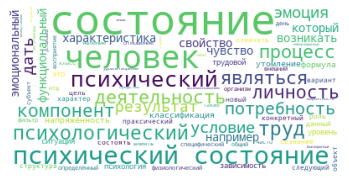

Название статьи: Психическое состояние


In [ ]:
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(d_norm[0]))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)
print('Название статьи:', keys[0])

### Векторизация и составление словаря

CountVectorizer преобразовывает входной текст в матрицу, значениями которой, являются количества вхождения данного ключа(слова) в текст. 
На этом этапе можно посмотреть, сколько раз слово встречается в данном тексте.

Рассмотрим последние 5 статей в корпусе:

In [ ]:
cv = CountVectorizer(stop_words=stop_words, max_features=10, ngram_range=(1,3))
t=0
for i in d_norm[:-5:-1]:
  X = cv.fit_transform([i])
  print(list(cv.vocabulary_.keys())[:10])
  t+=1
  print('Название статьи:', keys[-t])

['экзистенциальный', 'кризис', 'существование', 'смысл', 'жизнь', 'обычно', 'существо', 'собственный', 'человек', 'экзистенциальный кризис']
Название статьи: Экзистенциальный кризис
['экзальтация', 'воодушевление', 'повышенный', 'настроение', 'раздражение', 'психический', 'психический сфера', 'психиатрия термин', 'психический сфера проявляться', 'психиатрия термин экзальтация']
Название статьи: Экзальтация
['ужас', 'испуг', 'являться', 'оцепенение', 'реакция', 'угроза', 'возможность', 'событие', 'террор', 'итп']
Название статьи: Ужас
['уверенность', 'состояние', 'который', 'согласие', 'являться', 'знание', 'правда', 'личность', 'философия', 'выражение']
Название статьи: Уверенность


In [ ]:
# аналогичную операцию проведем с помощью FreqDist - 
# Распределение частот результатов эксперимента. Распределение частот регистрирует, сколько раз происходил каждый результат эксперимента.
t=0
for i in d_norm[:-5:-1]:
  s = nltk.word_tokenize(i)
  d1 = nltk.FreqDist(s)
  print(d1.most_common(5))
  t+=1
  print('Название статьи:', keys[-t])

[('кризис', 6), ('жизнь', 5), ('существование', 4), ('собственный', 4), ('экзистенциальный', 3)]
Название статьи: Экзистенциальный кризис
[('экзальтация', 2), ('воодушевление', 2), ('повышенный', 2), ('настроение', 2), ('лата', 1)]
Название статьи: Экзальтация
[('ужас', 3), ('являться', 3), ('угроза', 3), ('террор', 3), ('испуг', 2)]
Название статьи: Ужас
[('уверенность', 16), ('состояние', 4), ('который', 4), ('являться', 4), ('знание', 4)]
Название статьи: Уверенность


### Построение bi-grams

In [ ]:
# Наиболее часто втсречающиеся словосочетания
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=100).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

corpus = [d_norm[-17]]
top2_words = get_top_n2_words(corpus, n=10)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
print('Название статьи:', keys[-17])

                      Bi-gram  Freq
0         потребность человек    12
1         мера удовлетворение     4
2  удовлетворение потребность     4
3        потребность основный     4
4             потребность это     3
5               это позволять     3
6          активность человек     3
7      проявление потребность     3
8         потребность высокий     3
9    опредмечение потребность     3
Название статьи: Потребность


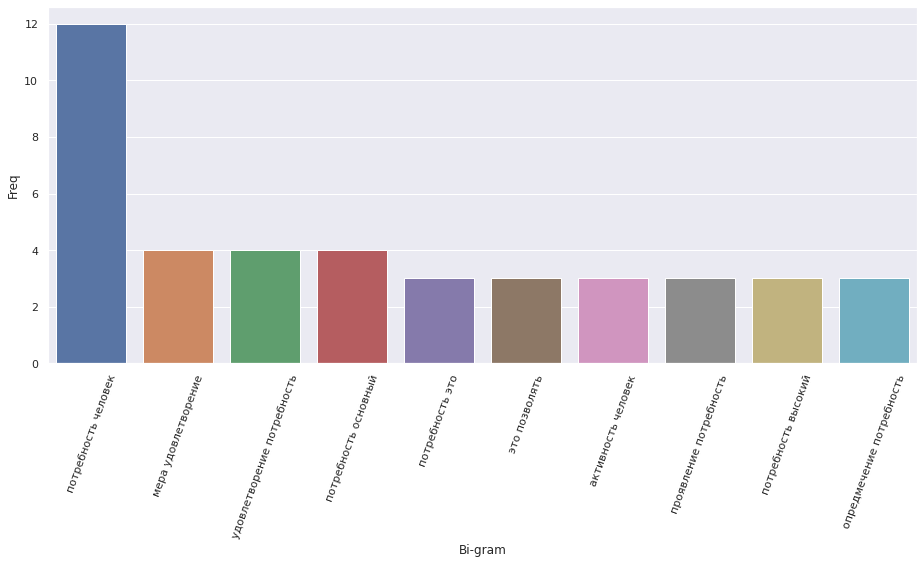

In [ ]:
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
plt.xticks(rotation=70)
plt.tight_layout()

### TF-IDF (term frequency-inverse document frequency)
Это простой и удобный способ оценить важность термина для какого-либо документа относительно всех остальных документов. Принцип такой — если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для того самого документа.

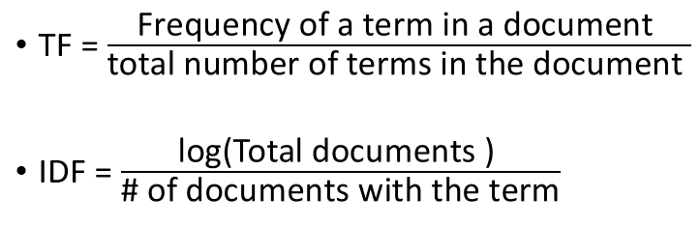

In [ ]:
cv = CountVectorizer(max_df = 0.8,stop_words = stop_words, max_features = 100, ngram_range = (1,3))
X = cv.fit_transform(d_norm)

In [ ]:
num = -17 #номер статьи 

In [ ]:
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer.fit(X)
# выбираем имена признаков 
feature_names = cv.get_feature_names()
 
# обозначаем с каким отдельным документом (а не корпусом) работаем
doc = d_norm[num]
 
# tf-idf вектор для данного документа
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# функция для сортировка tf-idf для убывающего порядка
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """берем имя признака и tf-idf значения для первых n сущностей"""
    
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # индекс слова и соответсвующего значения tf-idf 
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results


# сортировка
sorted_items=sort_coo(tf_idf_vector.tocoo())

# топ 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
print("Статья:")
print(doc)
print('Название статьи:', keys[num])
print("\nКлючевые слова:")
for k in keywords:
    print(k,keywords[k])

Статья:
потребность нужда внутренний состояние психологический функциональный ощущение недостаточность чеголибо проявляться зависимость ситуационный факторовпотребность вид функциональный психологический нужда недостаток какоголибо объект субъект индивид социальный группа общество являться внутренний возбудитель активность потребность проявляться поразный зависимость ситуациипотребность проявляться вид эмоционально окрасить желание влечение стремление удовлетворение вид оценочный эмоция потребность обнаруживаться личность мотив побуждать деятельность воспитание потребность один центральный задача формирование личностияркий пример служить жажда острый чувство потребность вода возникать обеднение она организм животное превышение кровь нормальный концентрация минеральный органический вещество физиологический механизм чувство воздействие повышенный общий осмотический давление изменение концентрация ион натрий происходить возбуждение питьевой центр головной мозг вызывающий нервногуморальный

### Gensim

В строке 1 (0, 1) означает, что слово с id = 0 появляется один раз в 1-м документе. Аналогично (4, 4) во втором элементе списка означает, что слово с идентификатором 4 встречается 4 раза во втором документе. И так далее.

In [ ]:
tokenized_list =  [[w for w in nltk.word_tokenize(doc)]]

mydict = corpora.Dictionary()
doc = d_norm[num]
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]
word_counts = [[(mydict[id], count) for id, count in line] for line in mycorpus]
word_counts[0].sort(key=lambda x:x[1], reverse = True)
print(word_counts[0][:10])
print('Название статьи:', keys[num])


[('потребность', 114), ('человек', 35), ('удовлетворение', 18), ('который', 13), ('вид', 11), ('деятельность', 10), ('животное', 10), ('состояние', 10), ('мотив', 9), ('уровень', 9)]
Название статьи: Потребность
